# Omost

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/notebooks/blob/main/notebooks/omost.ipynb)
[![Open in HF Spaces](https://huggingface.co/datasets/huggingface/badges/resolve/main/open-in-hf-spaces-sm-dark.svg)](https://huggingface.co/spaces/lllyasviel/Omost)

[Omost](https://github.com/lllyasviel/Omost) is a project from [Lvmin Zhang](https://github.com/lllyasviel) that incorporates a LLM (fine-tuned LLama 3 8B) with Stable Diffusion XL to improve the diffusion pipeline's compositional capabilities. It takes advantage of the LLM's ability to generate accurate Python code to create a `Canvas` class that contains a structured description of the global and local concepts in the image. During the diffusion process, attention is used to focus on the relevant parts of the canvas. This results in better spatial positioning of elements in the scene.

This notebook extracts the functionality from the Gradio app and adds [madebyollin/sdxl-vae-fp16-fix](https://huggingface.co/madebyollin/sdxl-vae-fp16-fix). I'm using [Juggernaut XL](https://huggingface.co/RunDiffusion/Juggernaut-XL-v9), so the results will look different than the original (RealVis). Based on commit [731e749](https://github.com/lllyasviel/Omost/commit/731e749).

## Install dependencies

Your runtime will crash and restart. This only runs once.

In [1]:
import os
import sys
import subprocess

from importlib.util import find_spec

# fmt: off
if not find_spec("accelerate") or not find_spec("bitsandbytes") or not find_spec("diffusers") or not find_spec("hf_transfer") or not find_spec("k_diffusion"):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "accelerate", "bitsandbytes", "diffusers", "hf-transfer", "k-diffusion"])
    os.kill(os.getpid(), 9)
# fmt: on

## Environment and configuration

In [2]:
try:
    import os
    from google.colab import userdata

    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
    os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
    OUT_DIR = "/content"
except ImportError:
    OUT_DIR = "."

HIGH_VRAM = False

SYSTEM_PROMPT = r"""You are a helpful AI assistant to compose images using the below Python class `Canvas`:

```python
class Canvas:
    def set_global_description(self, description: str, detailed_descriptions: list[str], tags: str, HTML_web_color_name: str):
        pass

    def add_local_description(self, location: str, offset: str, area: str, distance_to_viewer: float, description: str, detailed_descriptions: list[str], tags: str, atmosphere: str, style: str, quality_meta: str, HTML_web_color_name: str):
        assert location in ["in the center", "on the left", "on the right", "on the top", "on the bottom", "on the top-left", "on the top-right", "on the bottom-left", "on the bottom-right"]
        assert offset in ["no offset", "slightly to the left", "slightly to the right", "slightly to the upper", "slightly to the lower", "slightly to the upper-left", "slightly to the upper-right", "slightly to the lower-left", "slightly to the lower-right"]
        assert area in ["a small square area", "a small vertical area", "a small horizontal area", "a medium-sized square area", "a medium-sized vertical area", "a medium-sized horizontal area", "a large square area", "a large vertical area", "a large horizontal area"]
        assert distance_to_viewer > 0
        pass
```"""

## Imports

In [3]:
import copy
import difflib
import numpy as np
import re
import uuid
import torch

from contextlib import contextmanager
from k_diffusion.sampling import get_sigmas_karras, sample_dpmpp_2m
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers.models.transformers import Transformer2DModel
from diffusers.pipelines.stable_diffusion_xl.pipeline_stable_diffusion_xl_img2img import (
    StableDiffusionXLImg2ImgPipeline,
    StableDiffusionXLPipelineOutput,
    randn_tensor,
)
from PIL import Image
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    CLIPTextModel,
    CLIPTokenizer,
)

## Memory management

In [4]:
CPU = torch.device("cpu")
GPU = torch.device("cuda")

# Models to load: llm_model, text_encoder, text_encoder_2, unet, vae
MODELS_IN_GPU = []


# Temporarily remove the bitsandbytes quantization method to avoid error when moving between CPU and GPU.
@contextmanager
def movable_bnb_model(m):
    if hasattr(m, "quantization_method"):
        m.quantization_method_backup = m.quantization_method
        del m.quantization_method
    try:
        yield None
    finally:
        if hasattr(m, "quantization_method_backup"):
            m.quantization_method = m.quantization_method_backup
            del m.quantization_method_backup


# Simple memory management:
# - if HIGH_VRAM is False, move models to CPU when not in use
# - otherwise, keep models in GPU
def load_models_to_gpu(models):
    global MODELS_IN_GPU

    if not isinstance(models, (tuple, list)):
        models = [models]

    models_to_remain = [m for m in set(models) if m in MODELS_IN_GPU]
    models_to_load = [m for m in set(models) if m not in MODELS_IN_GPU]
    models_to_unload = [m for m in set(MODELS_IN_GPU) if m not in models_to_remain]

    if not HIGH_VRAM:
        for m in models_to_unload:
            with movable_bnb_model(m):
                m.to(CPU)
            print("Unload to CPU:", m.__class__.__name__)

        MODELS_IN_GPU = models_to_remain

    for m in models_to_load:
        with movable_bnb_model(m):
            m.to(GPU)
        print("Load to GPU:", m.__class__.__name__)

    MODELS_IN_GPU = list(set(MODELS_IN_GPU + models))
    torch.cuda.empty_cache()

## Canvas

In [5]:
# fmt: off
# Rather than draw complex shapes, simple rectangles are drawn.
valid_areas = {  # w, h in 90*90
    'a small square area': (50, 50),        'a small vertical area': (40, 60),        'a small horizontal area': (60, 40),
    'a medium-sized square area': (60, 60), 'a medium-sized vertical area': (50, 80), 'a medium-sized horizontal area': (80, 50),
    'a large square area': (70, 70),        'a large vertical area': (60, 90),        'a large horizontal area': (90, 60),
}

# The initial canvas is a 90*90 grid.
# Each valid location is an anchor point on the grid to draw the rectangle.
valid_locations = {  # x, y in 90*90
  'on the top-left': (15, 15),    'on the top': (45, 15),    'on the top-right': (75, 15),
  'on the left': (15, 45),        'in the center': (45, 45), 'on the right': (75, 45),
  'on the bottom-left': (15, 75), 'on the bottom': (45, 75), 'on the bottom-right': (75, 75),
}

# Offsets nudge the drawn rectangle slightly in a direction.
valid_offsets = {  # x, y in 90*90
    'slightly to the left': (-10, 0),         'slightly to the right': (10, 0),
    'slightly to the upper': (0, -10),        'slightly to the lower': (0, 10),
    'slightly to the upper-left': (-10, -10), 'slightly to the upper-right': (10, -10),
    'slightly to the lower-left': (-10, 10),  'slightly to the lower-right': (10, 10),
    'no offset': (0, 0),
}

# The LLM is fine-tuned to know what web colors are.
# When drawing the initial rectangle for each component, the web color is converted to RGB.
valid_colors = {  # r, g, b
    'aliceblue': (240, 248, 255),      'antiquewhite': (250, 235, 215),     'aqua': (0, 255, 255),                   'aquamarine': (127, 255, 212),
    'azure': (240, 255, 255),          'beige': (245, 245, 220),            'bisque': (255, 228, 196),               'black': (0, 0, 0),
    'blanchedalmond': (255, 235, 205), 'blue': (0, 0, 255),                 'blueviolet': (138, 43, 226),            'brown': (165, 42, 42),
    'burlywood': (222, 184, 135),      'cadetblue': (95, 158, 160),         'chartreuse': (127, 255, 0),             'chocolate': (210, 105, 30),
    'coral': (255, 127, 80),           'cornflowerblue': (100, 149, 237),   'cornsilk': (255, 248, 220),             'crimson': (220, 20, 60),
    'cyan': (0, 255, 255),             'darkblue': (0, 0, 139),             'darkcyan': (0, 139, 139),               'darkgoldenrod': (184, 134, 11),
    'darkgray': (169, 169, 169),       'darkgrey': (169, 169, 169),         'darkgreen': (0, 100, 0),                'darkkhaki': (189, 183, 107),
    'darkmagenta': (139, 0, 139),      'darkolivegreen': (85, 107, 47),     'darkorange': (255, 140, 0),             'darkorchid': (153, 50, 204),
    'darkred': (139, 0, 0),            'darksalmon': (233, 150, 122),       'darkseagreen': (143, 188, 143),         'darkslateblue': (72, 61, 139),
    'darkslategray': (47, 79, 79),     'darkslategrey': (47, 79, 79),       'darkturquoise': (0, 206, 209),          'darkviolet': (148, 0, 211),
    'deeppink': (255, 20, 147),        'deepskyblue': (0, 191, 255),        'dimgray': (105, 105, 105),              'dimgrey': (105, 105, 105),
    'dodgerblue': (30, 144, 255),      'firebrick': (178, 34, 34),          'floralwhite': (255, 250, 240),          'forestgreen': (34, 139, 34),
    'fuchsia': (255, 0, 255),          'gainsboro': (220, 220, 220),        'ghostwhite': (248, 248, 255),           'gold': (255, 215, 0),
    'goldenrod': (218, 165, 32),       'gray': (128, 128, 128),             'grey': (128, 128, 128),                 'green': (0, 128, 0),
    'greenyellow': (173, 255, 47),     'honeydew': (240, 255, 240),         'hotpink': (255, 105, 180),              'indianred': (205, 92, 92),
    'indigo': (75, 0, 130),            'ivory': (255, 255, 240),            'khaki': (240, 230, 140),                'lavender': (230, 230, 250),
    'lavenderblush': (255, 240, 245),  'lawngreen': (124, 252, 0),          'lemonchiffon': (255, 250, 205),         'lightblue': (173, 216, 230),
    'lightcoral': (240, 128, 128),     'lightcyan': (224, 255, 255),        'lightgoldenrodyellow': (250, 250, 210), 'lightgrey': (211, 211, 211),
    'lightgreen': (144, 238, 144),     'lightpink': (255, 182, 193),        'lightsalmon': (255, 160, 122),          'lightseagreen': (32, 178, 170),
    'lightskyblue': (135, 206, 250),   'lightslategrey': (119, 136, 153),   'lightsteelblue': (176, 196, 222),       'lightyellow': (255, 255, 224),
    'lime': (0, 255, 0),               'limegreen': (50, 205, 50),          'linen': (250, 240, 230),                'magenta': (255, 0, 255),
    'maroon': (128, 0, 0),             'mediumaquamarine': (102, 205, 170), 'mediumblue': (0, 0, 205),               'mediumorchid': (186, 85, 211),
    'mediumpurple': (147, 112, 219),   'mediumseagreen': (60, 179, 113),    'mediumslateblue': (123, 104, 238),      'mediumspringgreen': (0, 250, 154),
    'mediumturquoise': (72, 209, 204), 'mediumvioletred': (199, 21, 133),   'midnightblue': (25, 25, 112),           'mintcream': (245, 255, 250),
    'mistyrose': (255, 228, 225),      'moccasin': (255, 228, 181),         'navajowhite': (255, 222, 173),          'navy': (0, 0, 128),
    'navyblue': (0, 0, 128),           'oldlace': (253, 245, 230),          'olive': (128, 128, 0),                  'olivedrab': (107, 142, 35),
    'orange': (255, 165, 0),           'orangered': (255, 69, 0),           'orchid': (218, 112, 214),               'palegoldenrod': (238, 232, 170),
    'palegreen': (152, 251, 152),      'paleturquoise': (175, 238, 238),    'palevioletred': (219, 112, 147),        'papayawhip': (255, 239, 213),
    'peachpuff': (255, 218, 185),      'peru': (205, 133, 63),              'pink': (255, 192, 203),                 'plum': (221, 160, 221),
    'powderblue': (176, 224, 230),     'purple': (128, 0, 128),             'rebeccapurple': (102, 51, 153),         'red': (255, 0, 0),
    'rosybrown': (188, 143, 143),      'royalblue': (65, 105, 225),         'saddlebrown': (139, 69, 19),            'salmon': (250, 128, 114),
    'sandybrown': (244, 164, 96),      'seagreen': (46, 139, 87),           'seashell': (255, 245, 238),             'sienna': (160, 82, 45),
    'silver': (192, 192, 192),         'skyblue': (135, 206, 235),          'slateblue': (106, 90, 205),             'slategray': (112, 128, 144),
    'slategrey': (112, 128, 144),      'snow': (255, 250, 250),             'springgreen': (0, 255, 127),            'steelblue': (70, 130, 180),
    'tan': (210, 180, 140),            'teal': (0, 128, 128),               'thistle': (216, 191, 216),              'tomato': (255, 99, 71),
    'turquoise': (64, 224, 208),       'violet': (238, 130, 238),           'wheat': (245, 222, 179),                'white': (255, 255, 255),
    'whitesmoke': (245, 245, 245),     'yellow': (255, 255, 0),             'yellowgreen': (154, 205, 50)
}
# fmt: on


# Uses difflib fuzzy matching to find the closest name from the list of options.
# Used to correct potential typos from the LLM.
def closest_name(input_str, options):
    input_str = input_str.lower()
    closest_match = difflib.get_close_matches(
        input_str,
        list(options.keys()),
        n=1,
        cutoff=0.5,
    )
    assert (
        isinstance(closest_match, list) and len(closest_match) > 0
    ), f"The value [{input_str}] is not valid!"
    result = closest_match[0]

    if result != input_str:
        print(f"Automatically corrected [{input_str}] -> [{result}].")

    return result


def safe_str(x):
    return x.strip(",. ") + "."


class Canvas:
    @staticmethod
    def from_bot_response(response):
        # Response must be wrapped in a python fence
        matched = re.search(r"```python\n(.*?)\n```", response, re.DOTALL)
        assert matched, "Response does not contain codes!"
        code_content = matched.group(1)
        assert "canvas = Canvas()" in code_content, "Code block must include valid canvas var!"

        # Provide the `Canvas` class as a local variable and execute the code
        local_vars = {"Canvas": Canvas}
        exec(code_content, {}, local_vars)
        canvas = local_vars.get("canvas", None)
        assert isinstance(canvas, Canvas), "Code block must produce valid canvas var!"
        return canvas

    def __init__(self):
        self.components = []
        self.color = None
        self.record_tags = True
        self.prefixes = []
        self.suffixes = []

    # The global description refers to the overall scene
    def set_global_description(
        self,
        description,
        detailed_descriptions,
        tags,
        HTML_web_color_name,
    ):
        assert isinstance(description, str), "Global description is not valid!"
        assert isinstance(detailed_descriptions, list) and all(
            isinstance(item, str) for item in detailed_descriptions
        ), "Global detailed_descriptions is not valid!"
        assert isinstance(tags, str), "Global tags is not valid!"

        HTML_web_color_name = closest_name(HTML_web_color_name, valid_colors)
        self.color = np.array([[valid_colors[HTML_web_color_name]]], dtype=np.uint8)

        self.prefixes = [description]
        self.suffixes = detailed_descriptions

        if self.record_tags:
            self.suffixes = self.suffixes + [tags]

        self.prefixes = [safe_str(x) for x in self.prefixes]
        self.suffixes = [safe_str(x) for x in self.suffixes]

    # Local descriptions refer to a region of an image.
    # Each description results in a component (dict) made up of:
    #   * rectangle
    #   * color
    #   * distance to viewer
    #   * prompt prefix and suffix
    def add_local_description(
        self,
        location: str,
        offset: str,
        area: str,
        distance_to_viewer: float,
        description: str,
        detailed_descriptions: list[str],
        tags: str,
        atmosphere: str,
        style: str,
        quality_meta: str,
        HTML_web_color_name: str,
    ):
        assert isinstance(description, str), "Local description is wrong!"
        assert (
            isinstance(distance_to_viewer, (int, float)) and distance_to_viewer > 0
        ), f"The distance_to_viewer for [{description}] is not positive float number!"
        assert isinstance(detailed_descriptions, list) and all(
            isinstance(item, str) for item in detailed_descriptions
        ), f"The detailed_descriptions for [{description}] is not valid!"
        assert isinstance(tags, str), f"The tags for [{description}] is not valid!"
        assert isinstance(atmosphere, str), f"The atmosphere for [{description}] is not valid!"
        assert isinstance(style, str), f"The style for [{description}] is not valid!"
        assert isinstance(quality_meta, str), f"The quality_meta for [{description}] is not valid!"

        # Validate LLM output
        location = closest_name(location, valid_locations)
        offset = closest_name(offset, valid_offsets)
        area = closest_name(area, valid_areas)
        HTML_web_color_name = closest_name(HTML_web_color_name, valid_colors)

        # Calculate the rectangle and clamp it within the 90*90 grid
        xb, yb = valid_locations[location]
        xo, yo = valid_offsets[offset]
        w, h = valid_areas[area]
        rect = (yb + yo - h // 2, yb + yo + h // 2, xb + xo - w // 2, xb + xo + w // 2)
        rect = [max(0, min(90, i)) for i in rect]

        # Convert the web color to RGB
        color = np.array([[valid_colors[HTML_web_color_name]]], dtype=np.uint8)

        # Prefixes and suffixes construct the prompt (conditioning) for each local region of the image.
        # Custom cross-attention is used to focus each prompt on a specific region.
        prefixes = self.prefixes + [description]
        suffixes = detailed_descriptions

        if self.record_tags:
            suffixes = suffixes + [tags, atmosphere, style, quality_meta]

        prefixes = [safe_str(x) for x in prefixes]
        suffixes = [safe_str(x) for x in suffixes]

        self.components.append(
            {
                "rect": rect,
                "distance_to_viewer": distance_to_viewer,
                "color": color,
                "prefixes": prefixes,
                "suffixes": suffixes,
            }
        )

    def process(self):
        # Sort components by distance to viewer (nearest first)
        self.components = sorted(
            self.components,
            key=lambda x: x["distance_to_viewer"],
            reverse=True,
        )

        # Compute initial latent
        initial_latent = np.zeros(shape=(90, 90, 3), dtype=np.float16) + self.color

        for component in self.components:
            a, b, c, d = component["rect"]
            initial_latent[a:b, c:d] = 0.7 * component["color"] + 0.3 * initial_latent[a:b, c:d]

        initial_latent = initial_latent.clip(0, 255).astype(np.uint8)

        # Compute conditions
        bag_of_conditions = [
            {
                "mask": np.ones(shape=(90, 90), dtype=np.float16),
                "prefixes": self.prefixes,
                "suffixes": self.suffixes,
            }
        ]

        for _, component in enumerate(self.components):
            a, b, c, d = component["rect"]
            m = np.zeros(shape=(90, 90), dtype=np.float16)
            m[a:b, c:d] = 1.0
            bag_of_conditions.append(
                {
                    "mask": m,
                    "prefixes": component["prefixes"],
                    "suffixes": component["suffixes"],
                }
            )

        return {
            "initial_latent": initial_latent,
            "bag_of_conditions": bag_of_conditions,
        }

## Transformer2D hack

In [6]:
# Fixes `hidden_states_original_shape` not being passed to the attention processor.
original_Transformer2DModel_forward = Transformer2DModel.forward


def hacked_Transformer2DModel_forward(
    self,
    hidden_states,
    encoder_hidden_states=None,
    timestep=None,
    added_cond_kwargs=None,
    class_labels=None,
    cross_attention_kwargs=None,
    attention_mask=None,
    encoder_attention_mask=None,
    return_dict: bool = True,
):
    cross_attention_kwargs = cross_attention_kwargs or {}
    cross_attention_kwargs["hidden_states_original_shape"] = hidden_states.shape
    return original_Transformer2DModel_forward(
        self,
        hidden_states,
        encoder_hidden_states,
        timestep,
        added_cond_kwargs,
        class_labels,
        cross_attention_kwargs,
        attention_mask,
        encoder_attention_mask,
        return_dict,
    )


Transformer2DModel.forward = hacked_Transformer2DModel_forward

## Models

In [7]:
# Self-attention operates on the hidden state of the model.
class OmostSelfAttnProcessor:
    def __call__(
        self,
        attn,
        hidden_states,
        encoder_hidden_states,
        hidden_states_original_shape,
        *args,
        **kwargs,
    ):
        batch_size, _, _ = hidden_states.shape

        query = attn.to_q(hidden_states)
        key = attn.to_k(hidden_states)
        value = attn.to_v(hidden_states)

        inner_dim = key.shape[-1]
        head_dim = inner_dim // attn.heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        # Scaled dot product attention
        # https://paperswithcode.com/method/scaled
        # https://huggingface.co/docs/diffusers/optimization/torch2.0#scaled-dot-product-attention
        hidden_states = torch.nn.functional.scaled_dot_product_attention(
            query,
            key,
            value,
            attn_mask=None,
            dropout_p=0.0,
            is_causal=False,
        )

        hidden_states = hidden_states.transpose(1, 2).reshape(
            batch_size,
            -1,
            attn.heads * head_dim,
        )
        hidden_states = hidden_states.to(query.dtype)
        hidden_states = attn.to_out[0](hidden_states)
        hidden_states = attn.to_out[1](hidden_states)
        return hidden_states


# Cross-attention operates between the encoder outputs (embeddings) and the decoder inputs (hidden states).
# Each position in the hidden state is a Query vector.
# Key and Value vectors are derived from the encoder outputs (conds).
class OmostCrossAttnProcessor:
    def __call__(
        self,
        attn,
        hidden_states,
        encoder_hidden_states,
        hidden_states_original_shape,
        *args,
        **kwargs,
    ):
        # The masks (rectangles) are resized to the hidden state size.
        _, _, H, W = hidden_states_original_shape  # batch, channel, height, width
        conds = []
        masks = []

        for m, c in encoder_hidden_states:
            m = (
                torch.nn.functional.interpolate(m[None, None, :, :], (H, W), mode="nearest-exact")
                .flatten()
                .unsqueeze(1)
                .repeat(1, c.size(1))
            )
            conds.append(c)
            masks.append(m)

        conds = torch.cat(conds, dim=1)
        masks = torch.cat(masks, dim=1)

        mask_bool = masks > 0.5
        mask_scale = (H * W) / torch.sum(masks, dim=0, keepdim=True)

        batch_size, _, _ = conds.shape

        query = attn.to_q(hidden_states)
        key = attn.to_k(conds)
        value = attn.to_v(conds)

        inner_dim = key.shape[-1]
        head_dim = inner_dim // attn.heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        mask_bool = mask_bool[None, None, :, :].repeat(query.size(0), query.size(1), 1, 1)
        mask_scale = mask_scale[None, None, :, :].repeat(query.size(0), query.size(1), 1, 1)

        # The `mask_scale` and `mask_bool` are used to modify the attention weights.
        sim = query @ key.transpose(-2, -1) * attn.scale
        sim = sim * mask_scale.to(sim)
        sim.masked_fill_(mask_bool.logical_not(), float("-inf"))
        sim = sim.softmax(dim=-1)

        # The attention weights are used to compute the output.
        h = sim @ value
        h = h.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim)
        h = attn.to_out[0](h)
        h = attn.to_out[1](h)
        return h


class KModel:
    def __init__(self, unet, timesteps=1000, linear_start=0.00085, linear_end=0.012):
        betas = (
            torch.linspace(
                linear_start**0.5,
                linear_end**0.5,
                timesteps,
                dtype=torch.float16,
            )
            ** 2
        )
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.sigmas = ((1 - alphas_cumprod) / alphas_cumprod) ** 0.5
        self.log_sigmas = self.sigmas.log()
        self.sigma_data = 1.0
        self.unet = unet

    @property
    def sigma_min(self):
        return self.sigmas[0]

    @property
    def sigma_max(self):
        return self.sigmas[-1]

    # Map sigma to timestep in the diffusion process
    def timestep(self, sigma):
        log_sigma = sigma.log()
        dists = log_sigma.to(self.log_sigmas.device) - self.log_sigmas[:, None]
        return dists.abs().argmin(dim=0).view(sigma.shape).to(sigma.device)

    # Noise schedule using Karras method
    def get_sigmas(self, n):
        return get_sigmas_karras(
            n,
            sigma_min=self.sigma_min,
            sigma_max=self.sigma_max,
            device=self.unet.device,
        )

    def __call__(self, x, sigma, **extra_args):
        x_ddim_space = x / (sigma[:, None, None, None] ** 2 + self.sigma_data**2) ** 0.5
        t = self.timestep(sigma)
        cfg_scale = extra_args["cfg_scale"]
        eps_positive = self.unet(x_ddim_space, t, return_dict=False, **extra_args["positive"])[0]
        eps_negative = self.unet(x_ddim_space, t, return_dict=False, **extra_args["negative"])[0]
        noise_pred = eps_negative + cfg_scale * (eps_positive - eps_negative)
        return x - noise_pred * sigma[:, None, None, None]

## Pipeline

In [8]:
class StableDiffusionXLOmostPipeline(StableDiffusionXLImg2ImgPipeline):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.k_model = KModel(unet=self.unet)

        # Replace the default attention processors with our custom ones.
        attn_procs = {}
        for name in self.unet.attn_processors.keys():
            if name.endswith("attn2.processor"):
                attn_procs[name] = OmostCrossAttnProcessor()
            else:
                attn_procs[name] = OmostSelfAttnProcessor()

        self.unet.set_attn_processor(attn_procs)

    @torch.inference_mode()
    def encode_bag_of_subprompts_greedy(self, prefixes: list[str], suffixes: list[str]):
        device = self.text_encoder.device

        @torch.inference_mode()
        def greedy_partition(items, max_sum):
            bags = []
            current_bag = []
            current_sum = 0

            for item in items:
                num = item["length"]
                if current_sum + num > max_sum:
                    if current_bag:
                        bags.append(current_bag)
                    current_bag = [item]
                    current_sum = num
                else:
                    current_bag.append(item)
                    current_sum += num

            if current_bag:
                bags.append(current_bag)

            return bags

        @torch.inference_mode()
        def get_77_tokens_in_torch(subprompt_inds, tokenizer):
            # Note that all subprompt are theoretically less than 75 tokens (without bos/eos)
            result = (
                [tokenizer.bos_token_id]
                + subprompt_inds[:75]
                + [tokenizer.eos_token_id]
                + [tokenizer.pad_token_id] * 75
            )
            result = result[:77]
            result = torch.tensor([result]).to(device=device, dtype=torch.int64)
            return result

        @torch.inference_mode()
        def merge_with_prefix(bag):
            merged_ids_t1 = copy.deepcopy(prefix_ids_t1)
            merged_ids_t2 = copy.deepcopy(prefix_ids_t2)

            for item in bag:
                merged_ids_t1.extend(item["ids_t1"])
                merged_ids_t2.extend(item["ids_t2"])

            return {
                "ids_t1": get_77_tokens_in_torch(item["ids_t1"], self.tokenizer),
                "ids_t2": get_77_tokens_in_torch(item["ids_t2"], self.tokenizer_2),
            }

        @torch.inference_mode()
        def double_encode(pair_of_inds):
            inds = [pair_of_inds["ids_t1"], pair_of_inds["ids_t2"]]
            text_encoders = [self.text_encoder, self.text_encoder_2]

            pooled_prompt_embeds = None
            prompt_embeds_list = []

            for text_input_ids, text_encoder in zip(inds, text_encoders):
                prompt_embeds = text_encoder(text_input_ids, output_hidden_states=True)

                # Only last pooler_output is needed.
                pooled_prompt_embeds = prompt_embeds.pooler_output

                # "2" because SDXL always indexes from the penultimate layer.
                prompt_embeds = prompt_embeds.hidden_states[-2]
                prompt_embeds_list.append(prompt_embeds)

            prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)
            return prompt_embeds, pooled_prompt_embeds

        # Begin with tokenizing prefixes
        prefix_length = 0
        prefix_ids_t1 = []
        prefix_ids_t2 = []

        for prefix in prefixes:
            ids_t1 = self.tokenizer(prefix, truncation=False, add_special_tokens=False).input_ids
            ids_t2 = self.tokenizer_2(prefix, truncation=False, add_special_tokens=False).input_ids
            assert len(ids_t1) == len(ids_t2)
            prefix_length += len(ids_t1)
            prefix_ids_t1 += ids_t1
            prefix_ids_t2 += ids_t2

        # Then tokenizing suffixes
        allowed_suffix_length = 75 - prefix_length
        suffix_targets = []

        for subprompt in suffixes:
            # Note that all subprompt are theoretically less than 75 tokens (without bos/eos),
            # so we can safely just crop it to 75.
            ids_t1 = self.tokenizer(
                subprompt,
                truncation=False,
                add_special_tokens=False,
            ).input_ids[:75]
            ids_t2 = self.tokenizer_2(
                subprompt,
                truncation=False,
                add_special_tokens=False,
            ).input_ids[:75]
            assert len(ids_t1) == len(ids_t2)
            suffix_targets.append(
                {
                    "length": len(ids_t1),
                    "ids_t1": ids_t1,
                    "ids_t2": ids_t2,
                }
            )

        # Then merge prefix and suffix tokens
        suffix_targets = greedy_partition(suffix_targets, max_sum=allowed_suffix_length)
        targets = [merge_with_prefix(b) for b in suffix_targets]

        # Encode!
        conds, poolers = [], []
        for target in targets:
            cond, pooler = double_encode(target)
            conds.append(cond)
            poolers.append(pooler)

        conds_merged = torch.concat(conds, dim=1)
        poolers_merged = poolers[0]
        return {
            "cond": conds_merged,
            "pooler": poolers_merged,
        }

    @torch.inference_mode()
    def all_conds_from_canvas(self, canvas_outputs, negative_prompt):
        mask_all = torch.ones(size=(90, 90), dtype=torch.float16)
        negative_cond, negative_pooler = self.encode_cropped_prompt_77tokens(negative_prompt)
        negative_result = [(mask_all, negative_cond)]

        positive_result = []
        positive_pooler = None

        for item in canvas_outputs["bag_of_conditions"]:
            current_mask = torch.from_numpy(item["mask"]).to(torch.float16)
            current_prefixes = item["prefixes"]
            current_suffixes = item["suffixes"]

            current_cond = self.encode_bag_of_subprompts_greedy(
                prefixes=current_prefixes,
                suffixes=current_suffixes,
            )

            if positive_pooler is None:
                positive_pooler = current_cond["pooler"]

            positive_result.append((current_mask, current_cond["cond"]))

        return positive_result, positive_pooler, negative_result, negative_pooler

    @torch.inference_mode()
    def encode_cropped_prompt_77tokens(self, prompt: str):
        device = self.text_encoder.device
        tokenizers = [self.tokenizer, self.tokenizer_2]
        text_encoders = [self.text_encoder, self.text_encoder_2]

        pooled_prompt_embeds = None
        prompt_embeds_list = []

        for tokenizer, text_encoder in zip(tokenizers, text_encoders):
            text_input_ids = tokenizer(
                prompt,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            ).input_ids

            prompt_embeds = text_encoder(text_input_ids.to(device), output_hidden_states=True)

            # Only last pooler_output is needed
            pooled_prompt_embeds = prompt_embeds.pooler_output

            # "2" because SDXL always indexes from the penultimate layer.
            prompt_embeds = prompt_embeds.hidden_states[-2]
            prompt_embeds_list.append(prompt_embeds)

        prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)
        prompt_embeds = prompt_embeds.to(dtype=self.unet.dtype, device=device)
        return prompt_embeds, pooled_prompt_embeds

    @torch.inference_mode()
    def __call__(
        self,
        initial_latent=None,
        strength=1.0,
        num_inference_steps=25,
        guidance_scale=5.0,
        batch_size=1,
        generator=None,
        prompt_embeds=None,
        negative_prompt_embeds=None,
        pooled_prompt_embeds=None,
        negative_pooled_prompt_embeds=None,
        cross_attention_kwargs=None,
    ):
        device = self.unet.device
        cross_attention_kwargs = cross_attention_kwargs or {}

        # Sigmas (noise schedule)
        sigmas = self.k_model.get_sigmas(int(num_inference_steps / strength))
        sigmas = sigmas[-(num_inference_steps + 1) :]

        # Initial latents
        _, C, H, W = initial_latent.shape  # batch, channel, height, width
        noise = randn_tensor(
            (batch_size, C, H, W),
            generator=generator,
            device=device,
            dtype=self.unet.dtype,
        )
        latents = initial_latent.to(noise) + noise * sigmas[0].to(noise)

        # Shape
        height, width = latents.shape[-2:]
        height = height * self.vae_scale_factor
        width = width * self.vae_scale_factor

        add_time_ids = list((height, width) + (0, 0) + (height, width))
        add_time_ids = torch.tensor([add_time_ids], dtype=self.unet.dtype)
        add_neg_time_ids = add_time_ids.clone()

        # Batch
        latents = latents.to(device)
        add_time_ids = add_time_ids.repeat(batch_size, 1).to(device)
        add_neg_time_ids = add_neg_time_ids.repeat(batch_size, 1).to(device)
        prompt_embeds = [(k.to(device), v.repeat(batch_size, 1, 1).to(noise)) for k, v in prompt_embeds]
        negative_prompt_embeds = [
            (k.to(device), v.repeat(batch_size, 1, 1).to(noise)) for k, v in negative_prompt_embeds
        ]
        pooled_prompt_embeds = pooled_prompt_embeds.repeat(batch_size, 1).to(noise)
        negative_pooled_prompt_embeds = negative_pooled_prompt_embeds.repeat(batch_size, 1)
        negative_pooled_prompt_embeds = negative_pooled_prompt_embeds.to(noise)

        # Feeds
        sampler_kwargs = {
            "cfg_scale": guidance_scale,
            "positive": {
                "encoder_hidden_states": prompt_embeds,
                "added_cond_kwargs": {
                    "text_embeds": pooled_prompt_embeds,
                    "time_ids": add_time_ids,
                },
                "cross_attention_kwargs": cross_attention_kwargs,
            },
            "negative": {
                "encoder_hidden_states": negative_prompt_embeds,
                "added_cond_kwargs": {
                    "text_embeds": negative_pooled_prompt_embeds,
                    "time_ids": add_neg_time_ids,
                },
                "cross_attention_kwargs": cross_attention_kwargs,
            },
        }

        # Sample
        results = sample_dpmpp_2m(
            self.k_model,
            latents,
            sigmas,
            extra_args=sampler_kwargs,
            disable=False,
        )
        return StableDiffusionXLPipelineOutput(images=results)

## Inference functions

In [9]:
@torch.inference_mode()
def pytorch2numpy(imgs):
    results = []
    for x in imgs:
        y = x.movedim(0, -1)
        y = y * 127.5 + 127.5
        y = y.detach().float().cpu().numpy().clip(0, 255).astype(np.uint8)
        results.append(y)
    return results


@torch.inference_mode()
def numpy2pytorch(imgs):
    h = torch.from_numpy(np.stack(imgs, axis=0)).float() / 127.5 - 1.0
    h = h.movedim(-1, 1)
    return h


def resize_without_crop(image, target_width, target_height):
    pil_image = Image.fromarray(image)
    resized_image = pil_image.resize((target_width, target_height), Image.LANCZOS)
    return np.array(resized_image)


@torch.inference_mode()
def chat_fn(
    llm_model,
    llm_tokenizer,
    message,
    history,
    seed,
    temperature,
    top_p,
    max_new_tokens,
):
    np.random.seed(int(seed))
    torch.manual_seed(int(seed))

    conversation = [{"role": "system", "content": SYSTEM_PROMPT}]

    for user, assistant in history:
        if isinstance(user, str) and isinstance(assistant, str):
            if len(user) > 0 and len(assistant) > 0:
                conversation.extend(
                    [
                        {"role": "user", "content": user},
                        {"role": "assistant", "content": assistant},
                    ]
                )

    conversation.append({"role": "user", "content": message})

    load_models_to_gpu(llm_model)

    input_ids = llm_tokenizer.apply_chat_template(
        conversation,
        return_tensors="pt",
        add_generation_prompt=True,
    ).to(llm_model.device)
    input_length = input_ids.shape[-1]

    # https://stackoverflow.com/questions/69609401/suppress-huggingface-logging-warning-setting-pad-token-id-to-eos-token-id
    output_ids = llm_model.generate(
        pad_token_id=llm_tokenizer.eos_token_id,
        input_ids=input_ids,
        max_new_tokens=max_new_tokens,
        do_sample=temperature > 0,
        temperature=temperature,
        top_p=top_p,
    )

    # Skip the input tokens when decoding the response
    input_length = input_ids.shape[-1]
    output_text = llm_tokenizer.decode(output_ids[0, input_length:], skip_special_tokens=True)
    return output_text


@torch.inference_mode()
def diffusion_fn(
    text_encoder,
    text_encoder_2,
    pipeline,
    unet,
    vae,
    history,
    num_samples,
    seed,
    image_width,
    image_height,
    steps,
    cfg,
    highres_scale,
    highres_steps,
    highres_denoise,
    negative_prompt,
):
    canvas_outputs = None
    try:
        if history:
            history = [
                (user, assistant)
                for user, assistant in history
                if isinstance(user, str) and isinstance(assistant, str)
            ]
            last_assistant = history[-1][1] if len(history) > 0 else None
            canvas = Canvas.from_bot_response(last_assistant)
            canvas_outputs = canvas.process()
    except Exception as e:
        print("Last assistant response is not valid canvas:", e)

    image_width, image_height = (
        int(image_width // 64) * 64,
        int(image_height // 64) * 64,
    )

    rng = torch.Generator(device=GPU).manual_seed(seed)

    load_models_to_gpu([text_encoder, text_encoder_2])

    positive_cond, positive_pooler, negative_cond, negative_pooler = pipeline.all_conds_from_canvas(
        canvas_outputs,
        negative_prompt,
    )

    initial_latent = torch.zeros(
        size=(num_samples, 4, image_height // 8, image_width // 8),
        dtype=torch.float16,
    )

    load_models_to_gpu([unet])

    initial_latent = initial_latent.to(dtype=unet.dtype, device=unet.device)

    latents = pipeline(
        initial_latent=initial_latent,
        strength=1.0,
        num_inference_steps=int(steps),
        batch_size=num_samples,
        prompt_embeds=positive_cond,
        negative_prompt_embeds=negative_cond,
        pooled_prompt_embeds=positive_pooler,
        negative_pooled_prompt_embeds=negative_pooler,
        generator=rng,
        guidance_scale=float(cfg),
    ).images

    load_models_to_gpu([vae])

    latents = latents.to(dtype=vae.dtype, device=vae.device) / vae.config.scaling_factor
    pixels = vae.decode(latents).sample
    _, _, H, W = pixels.shape  # batch, channel, height, width
    pixels = pytorch2numpy(pixels)

    eps = 0.05
    if highres_scale > 1.0 + eps:
        pixels = [
            resize_without_crop(
                image=p,
                target_width=int(round(W * highres_scale / 64.0) * 64),
                target_height=int(round(H * highres_scale / 64.0) * 64),
            )
            for p in pixels
        ]

        pixels = numpy2pytorch(pixels).to(device=vae.device, dtype=vae.dtype)
        latents = vae.encode(pixels).latent_dist.mode() * vae.config.scaling_factor

        load_models_to_gpu([unet])
        latents = latents.to(device=unet.device, dtype=unet.dtype)

        latents = pipeline(
            initial_latent=latents,
            strength=highres_denoise,
            num_inference_steps=highres_steps,
            batch_size=num_samples,
            prompt_embeds=positive_cond,
            negative_prompt_embeds=negative_cond,
            pooled_prompt_embeds=positive_pooler,
            negative_pooled_prompt_embeds=negative_pooler,
            generator=rng,
            guidance_scale=float(cfg),
        ).images

        load_models_to_gpu([vae])
        latents = latents.to(dtype=vae.dtype, device=vae.device) / vae.config.scaling_factor
        pixels = vae.decode(latents).sample
        pixels = pytorch2numpy(pixels)

    image_paths = []
    for i in range(len(pixels)):
        unique_hex = uuid.uuid4().hex
        image_path = f"{OUT_DIR}/{unique_hex}_{i}.png"
        image = Image.fromarray(pixels[i])
        image.save(image_path)
        image_paths.append(image_path)
        print(f"Saved {image_path}")

    return image_paths

## Load models

In [10]:
LLM_NAME = "lllyasviel/omost-llama-3-8b-4bits"  # @param ["lllyasviel/omost-llama-3-8b-4bits", "lllyasviel/omost-dolphin-2.9-llama3-8b-4bits"]
SDXL_NAME = "RunDiffusion/Juggernaut-XL-v9"  # @param ["RunDiffusion/Juggernaut-XL-v9", "SG161222/RealVisXL_V4.0", "stabilityai/stable-diffusion-xl-base-1.0"]

# Unload all
load_models_to_gpu([])

llm_tokenizer = AutoTokenizer.from_pretrained(LLM_NAME)
llm_model = AutoModelForCausalLM.from_pretrained(
    LLM_NAME,
    torch_dtype=torch.float16,
    device_map="auto",  # This will load model to gpu with an offload system
)

tokenizer = CLIPTokenizer.from_pretrained(SDXL_NAME, subfolder="tokenizer")
tokenizer_2 = CLIPTokenizer.from_pretrained(SDXL_NAME, subfolder="tokenizer_2")

text_encoder = CLIPTextModel.from_pretrained(
    SDXL_NAME,
    subfolder="text_encoder",
    torch_dtype=torch.float16,
    variant="fp16",
)
text_encoder_2 = CLIPTextModel.from_pretrained(
    SDXL_NAME,
    subfolder="text_encoder_2",
    torch_dtype=torch.float16,
    variant="fp16",
)
vae = AutoencoderKL.from_single_file(
    "https://huggingface.co/madebyollin/sdxl-vae-fp16-fix/blob/main/sdxl.vae.safetensors"
)
unet = UNet2DConditionModel.from_pretrained(
    SDXL_NAME,
    subfolder="unet",
    torch_dtype=torch.float16,
    variant="fp16",
)

# See KModel for scheduler
pipeline = StableDiffusionXLOmostPipeline(
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    text_encoder_2=text_encoder_2,
    tokenizer_2=tokenizer_2,
    unet=unet,
    vae=vae,
    scheduler=None,
)

## Generate canvas from LLM

In [11]:
SEED = 42  # @param {type:"integer"}
MAX_NEW_TOKENS = 4096  # @param {type:"integer"}
PROMPT = "cat"  # @param {type:"string"}
NEGATIVE_PROMPT = "ugly, deformed, noisy, blurry, distorted, grainy"  # @param {type:"string"}
TEMPERATURE = 0.6  # @param {type:"slider",min:0.0,max:2.0,step:0.01}
TOP_P = 0.9  # @param {type:"slider",min:0.0,max:1.0,step:0.01}
SHOW_CANVAS = True  # @param {type:"boolean"}

chat_response = chat_fn(
    llm_model,
    llm_tokenizer,
    PROMPT,
    [],
    seed=SEED,
    temperature=TEMPERATURE,
    top_p=TOP_P,
    max_new_tokens=MAX_NEW_TOKENS,
)

if SHOW_CANVAS:
    print(chat_response)

You shouldn't move a model that is dispatched using accelerate hooks.


Load to GPU: LlamaForCausalLM
```python
# Initialize the canvas
canvas = Canvas()

# Set a global description for the canvas
canvas.set_global_description(
    description='A serene image of a cat in a peaceful environment.',
    detailed_descriptions=[
        'The image captures a tranquil scene featuring a cat.',
        'The cat is sitting gracefully, with its fur glistening under the soft, natural light.',
        'The background includes a lush green garden with blooming flowers, creating a serene and idyllic atmosphere.',
        'The sky is clear with a few fluffy clouds, adding to the calmness of the scene.',
        'The overall ambiance is peaceful, with the cat being the central focus, exuding a sense of calm and contentment.',
    ],
    tags='cat, serene, peaceful, garden, flowers, natural light, fluffy clouds, calm, content, central focus, fur, glistening, lush green, idyllic, tranquil, soft light, sky, clear, fluffy clouds, ambiance, peaceful, central focus, fur, gliste

## Generate images from canvas

You shouldn't move a model that is dispatched using accelerate hooks.


Unload to CPU: LlamaForCausalLM
Load to GPU: CLIPTextModel
Load to GPU: CLIPTextModel
Unload to CPU: CLIPTextModel
Unload to CPU: CLIPTextModel
Load to GPU: UNet2DConditionModel


  0%|          | 0/30 [00:00<?, ?it/s]

Unload to CPU: UNet2DConditionModel
Load to GPU: AutoencoderKL
Saved ./5becc531a21140c395514e5f71ac91a9_0.png


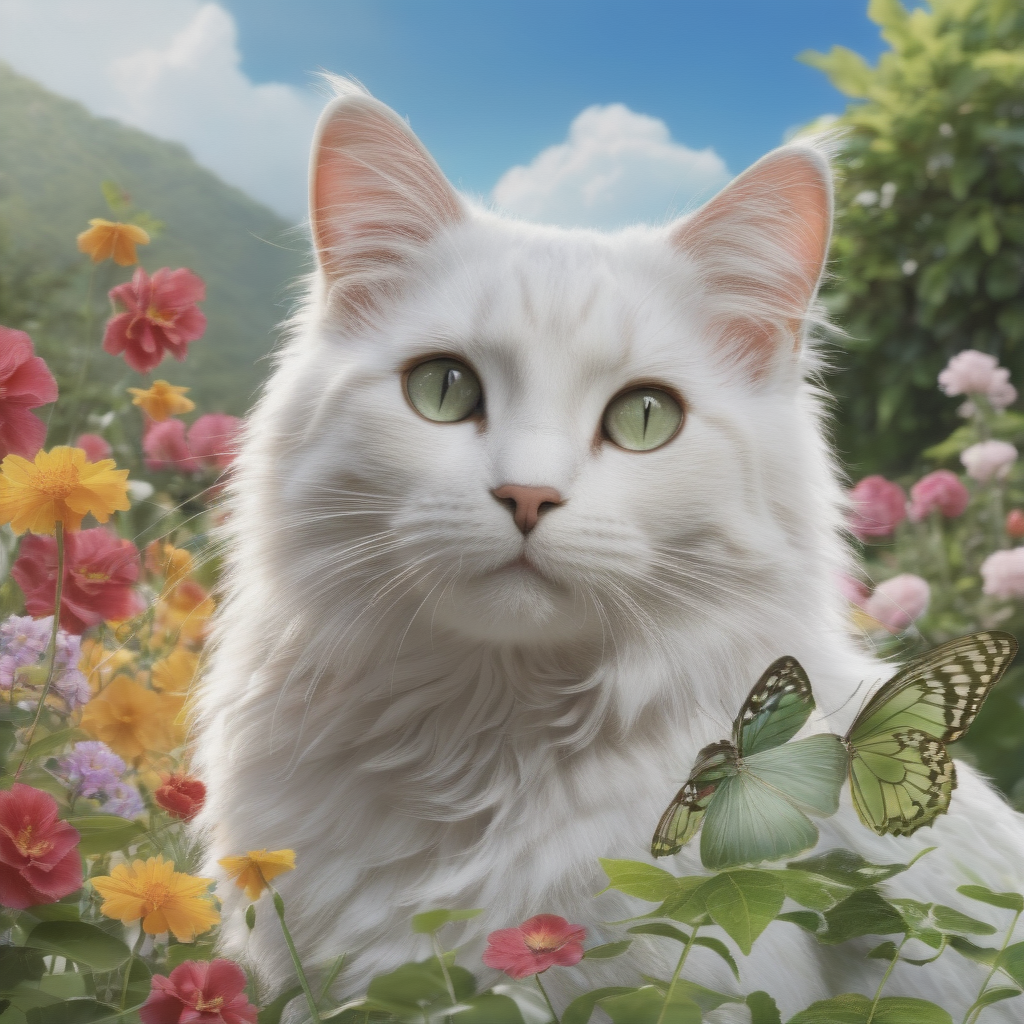

In [12]:
NUM_SAMPLES = 1  # @param {type:"integer"}
IMAGE_SEED = 42  # @param {type:"integer"}
IMAGE_WIDTH = 1024  # @param {type:"integer"}
IMAGE_HEIGHT = 1024  # @param {type:"integer"}
STEPS = 30  # @param {type:"slider",min:1,max:100,step:1}
CFG = 6  # @param {type:"slider",min:1.0,max:32.0,step:0.1}
HIGHRES_SCALE = 1.0  # @param {type:"slider",min:1.0,max:2.0,step:0.01}
HIGHRES_STEPS = 20  # @param {type:"slider",min:1,max:100,step:1}
HIGHRES_DENOISE = 0.4  # @param {type:"slider",min:0.0,max:1.0,step:0.01}

history = [(PROMPT, chat_response)]
image_paths = diffusion_fn(
    text_encoder=text_encoder,
    text_encoder_2=text_encoder_2,
    pipeline=pipeline,
    unet=unet,
    vae=vae,
    history=history,
    num_samples=NUM_SAMPLES,
    seed=IMAGE_SEED,
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    steps=STEPS,
    cfg=CFG,
    highres_scale=HIGHRES_SCALE,
    highres_steps=HIGHRES_STEPS,
    highres_denoise=HIGHRES_DENOISE,
    negative_prompt=NEGATIVE_PROMPT,
)

for image_path in image_paths:
    display(Image.open(image_path))